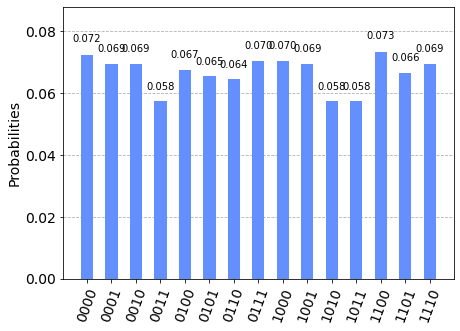

In [3]:
from qiskit import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from math import acos, sqrt, ceil, log


def even_superpositon(circuit, register, controls, ancilla, P):
    if P <= pow(2, len(register)) / 2: # skip this iteration
        even_superpositon(circuit, register[1:], controls, ancilla, P)
        return
    if P == pow(2, len(register)): # reduced to H_ALL; base case
        if controls == []:
            print("H_ALL!")
            for qb in register:
                circuit.h(qb)
        elif len(register) > 0:
            circuit.mcx(controls, ancilla) # mcx to ancilla used in lieu of mch
            for qb in register:
                circuit.ch(ancilla, qb)
            circuit.mcx(controls, ancilla)
        return


    extra_parts = P - pow(2, len(register) - 1)
    # this is the inverse of what we want, but saves us an X for ch
    theta = 2 * acos(sqrt(extra_parts / P))

    if controls == []:
        circuit.ry(theta, register[0])
        for i in range(1, len(register)):
            circuit.ch(register[0], register[i])
        controls += [register[0]]
    else:
        circuit.mcry(theta, controls, register[0])
        controls += [register[0]]
        circuit.mcx(controls + [], ancilla)
        for i in range(1, len(register)):
            circuit.ch(ancilla, register[i])
        circuit.mcx(controls, ancilla)

    circuit.x(register[0])


    even_superpositon(circuit, register[1:], controls, ancilla, extra_parts)


parts = 15
length = ceil(log(parts, 2))
resister = QuantumRegister(length, name="reg")
classic = ClassicalRegister(length, name="measure")
ancilla = QuantumRegister(1, name="anc")
circ = QuantumCircuit(resister, ancilla, classic)

even_superpositon(circ, resister, [], ancilla, parts)
circ.barrier()
circ.measure(resister, classic)


circ.draw(output="mpl", filename='example_circuit.png', fold=40, plot_barriers=True)


sim = Aer.get_backend('aer_simulator')
res = execute(circ, sim, shots=1024).result()
count = res.get_counts(circ)
newcount = {key[::-1]: b for key, b in count.items()}
plot_histogram(newcount)

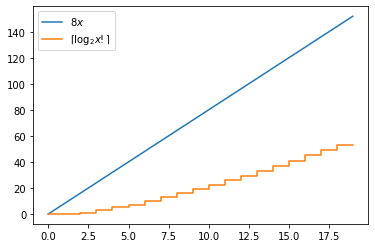

In [4]:
from scipy.special import gamma

x = np.arange(0, 20)
first = 8 * x
second = np.ceil(np.log2(gamma(x)))
plt.plot(x, first)
plt.step(x, second)
plt.legend((r"$8x$", r"$\lceil \log_2 x! \rceil$"))
plt.savefig("size_compare.png")

In [6]:
from itertools import permutations
from time import perf_counter

set = [6, 10, 2589, 0, 47, 178]
possibilities = list(permutations(set))
set.sort()

sorted = tuple(set)

parts = len(possibilities)
length = ceil(log(parts, 2))
register = QuantumRegister(length)
measurement = ClassicalRegister(length)
ancilla = QuantumRegister(1)
circuit = QuantumCircuit(register, ancilla, measurement)

even_superpositon(circuit, register, [], ancilla, parts)
circuit.measure(register, measurement)

start = perf_counter()
while True:
    counts = execute(circuit, Aer.get_backend("aer_simulator"), shots=500).result().get_counts(circuit)

    max_count = 0
    index = None
    for num, count in counts.items():
        if count > max_count:
            max_count = count
            index = int(num[::-1], 2)

    if index is not None:
        if possibilities[index] == sorted:
            break
end = perf_counter()

print(f"Finished Quantum Bogosort in {end-start} seconds on list of length {len(set)}")

Finished Quantum Bogosort in 43.87339369999995 seconds on list of length 6


In [ ]:
# I did NOT write qasm2circ, all credit goes to prof. chuang
import subprocess

prelude = """\documentclass[preview]{standalone}
\usepackage{graphicx}
% xyqcirc stuff
\usepackage[frame,line,arrow,matrix,tips]{xy}	% all that is usually necessary
\begin{document}"""

with open("./images/circuits/conceptual_circuit.tex", 'w') as f:
    f.write(prelude)
with open("./images/circuits/optimized_circuit.tex", 'w') as f:
    f.write(prelude)

subprocess.run(["python2", "qasm2tex.py", "conceptual_circuit.qasm", ">>", "./paper/images/circuits/conceptual_circuit.tex"])
subprocess.run(["python2", "qasm2tex.py", "optimized_circuit.qasm", ">>", "./paper/images/circuits/optimized_circuit.tex"])

In [ ]:
from resource_estimation import depthGrapher

depthGrapher(256)

In [7]:
from qiskit.providers import ibmq as ibm_provider
from qiskit import IBMQ
from statistics import mean


# using QRNQ as an example
parts = 15
length = ceil(log(parts, 2))
resister = QuantumRegister(length, name="reg")
classic = ClassicalRegister(length, name="measure")
ancilla = QuantumRegister(1, name="anc")
circ = QuantumCircuit(resister, ancilla, classic)

even_superpositon(circ, resister, [], ancilla, parts)
circ.barrier()
circ.measure(resister, classic)


qubits = len(circ.qubits)

p = IBMQ.load_account()
c = [i.properties().to_dict() for i in p.backends() if type(i) is ibm_provider.IBMQBackend]

for comp in c:
    gate_error = {}
    for gate in comp["gates"]:
        t = tuple(gate["qubits"]) + (gate["parameters"][0]["value"],)
        if gate_error.get(gate["gate"]) is None:
            gate_error[gate["gate"]] = [t]
        else:
            gate_error[gate["gate"]].append(t)

data = [{"name": comp["backend_name"],
        "qubits": len(comp["qubits"]),
        "t1": mean([t[0]["value"] for t in comp["qubits"]]),
        "read_error": mean([e[4]["value"] for e in comp["qubits"]]),
        "gates": [{"name": g["gate"], "error": g["parameters"][0]["value"]} for g in comp["gates"] if g["gate"] != "reset"]
        } for comp in c]

print(data)

def find_computer(computers, count):
    comps = []
    maxq = -1
    for i in computers:
        if (q := i["qubits"]) >= count:
            if maxq == -1:
                maxq = q
            elif q == maxq:
                comps.append(i)
            else:
                break
    if maxq == -1:
        raise Exception("You don't have access to a quantum computer with sufficient qubits. Try setting all_backends to true.")
    return comps
   
optimals = find_computer(data, qubits)
f = transpile(circ, backend=p.get_backend(optimals[0]["name"]), optimization_level=1)
#f.draw(output="mpl", filename="example_qasm.png")

# this function does not work... technically.
# by only calculating the % that every gate succeeds, our expected probability is astronomically small (in the order of 1 in 10^^4... smaller than even the decimal library is able to represent)
# this could be properly implemented if one calculated the probabilities of all permutation of mistakes that result in a successful measurement
# this is still rather tenous, as error measurement is really a discrepancy in the manipulation of qubits and not a binary thing
# consequently, I advise those who would implement this to instead use gate error to turn all gates into applied-error rotation gates and see where each qubit is expected to end up
# again, not ideal, but better than the alternative. perhaps this is a job best suited to a statistician
def average_gate_error(computers, circ):
    for comp in computers:
        probabilities = [1 for _ in circ.num_qubits]
        new_circ = transpile(circ, backend=p.get_backend(comp["name"]), optimization_level=1)
        for instr in new_circ.data:
            gate = instr[0].name
            # todo: extend to multi-qubit gates
            # hold on... multi-qubit gates should almost certainly be implemented as compositions of single qubit gates. check back on this
            # does this involve finding the gate (ex. ccQFT0,2_3,4,5) to find which are controls and which are part of the gate?
            # wait, I'm being stupid... the last few gates are just the width of the gate!
            # I think we still have to figure out how to find that out...

            # I think implementation details get wacky here... if so that's REALLY messed up. Bad Qiskit authors!
            # ubuntu wins over osx implementation
            control = instr[1][1]
            acted = instr[1][-1]

average_gate_error(optimals, f)

{'id': [(0, 0.00023547273212588197)], 'rz': [(0, 0)], 'sx': [(0, 0.00023547273212588197)], 'x': [(0, 0.00023547273212588197)]}


'\ndata = [{"name": comp["backend_name"],\n        "qubits": len(comp["qubits"]),\n        "t1": mean([t[0]["value"] for t in comp["qubits"]]),\n        "read_error": mean([e[4]["value"] for e in comp["qubits"]]),\n        "gates": [{"name": g["gate"], "error": g["parameters"][0]["value"]} for g in comp["gates"] if g["gate"] != "reset"]\n        } for comp in c]\n\ndef find_computer(computers, count):\n    #todo: add code to choose based on t1 and readout error\n    # nvm refactor that elsewhere\n    comps = []\n    maxq = -1\n    for i in computers:\n        if (q := i["qubits"]) >= count:\n            if maxq == -1:\n                maxq = q\n            elif q == maxq:\n                comps.append(i)\n            else:\n                break\n    if maxq == -1:\n        raise Exception("You don\'t have access to a quantum computer with sufficient qubits. Try setting all_backends to true.")\n    return comps\n   \nbeef = find_computer(data, qubits)\n\nf = transpile(circ, backend=p.g